In [1]:
# Import packages as needed. Maybe PIL?
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import YAArrow

import numpy as np

import textwrap

from astropy.io import ascii, fits

In [40]:
def spectraChart():
    
    # set up figure 
    f, axs = plt.subplots(4, sharex = True, figsize=(16,16))
    f.set_facecolor('white')
    f.canvas.set_window_title("Spectra")

  
    plt.style.use('fivethirtyeight')
    
    axs[-1].set_xlim(0.3,1)
    axs[-1].set_xlabel('Wavelength ($\mu m$)')
    axs[0].set_title("Spectra")
    
    # SDSS filters
    # Doi, M., Tanaka, M., Fukugita, M., Gunn, J. E., Yasuda, N., Ivezić, Ž., ... & Leger, R. F. (2010). Photometric response functions of the sloan digital sky survey imager. The Astronomical Journal, 139(4), 1628.
    sdssGrizy = ascii.read('grizyFilters.txt',format='tab')
    sdssPlt = 3
    
    axs[sdssPlt].set_ylabel("SDSS Filter Response")
    lambdaMicron = sdssGrizy['lambda']*(10**-4)
    axs[sdssPlt].plot(lambdaMicron,sdssGrizy['u'],'#008fd5',label='u')
    axs[sdssPlt].plot(lambdaMicron,sdssGrizy['g'],'#6d904f',label='g')
    axs[sdssPlt].plot(lambdaMicron,sdssGrizy['r'],'#fc4f30',label='r')
    axs[sdssPlt].plot(lambdaMicron,sdssGrizy['i'],'#810f7c',label='i')
    axs[sdssPlt].plot(lambdaMicron,sdssGrizy['z'],'#8b8b8b',label='z')
    axs[sdssPlt].legend()
    
    # Solar spectrum
    # http://www.eso.org/observing/dfo/quality/UVES/pipeline/solar_spectrum.html
    fitsData = fits.open("solar_spectrum.fits")
    solarSpec = fitsData[0].data
    fitsData.close()
    solPlt = 2
    
    axs[solPlt].set_ylabel("UVES solar spectrum (flux)")
    #axs[solPlt].set_ylim(-0.5,1.5)
    
    xvals = np.zeros(len(solarSpec))
    xvals[0] = 3000
    for i in range(1,len(xvals)):
        xvals[i] = xvals[i-1] + 0.0124862
    axs[solPlt].plot(xvals*(10**-4),solarSpec,'#e5ae38')
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    
    plt.tight_layout()    
    plt.savefig('spectra.pdf')
    plt.show()

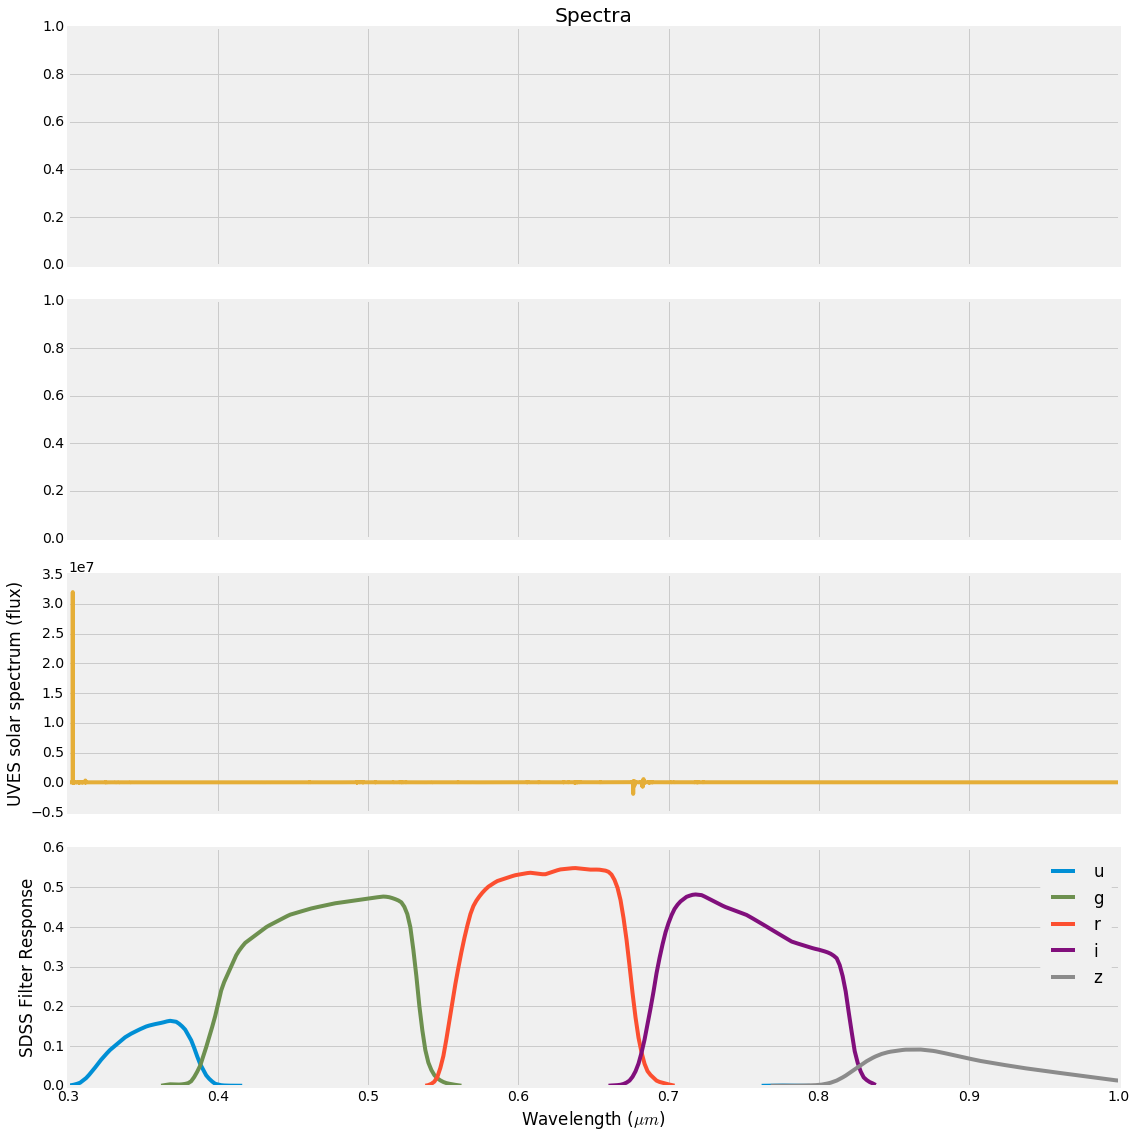

In [41]:
spectraChart()